In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sympy as sp

In [2]:
from IPython.display import Math, display

In [3]:
from compute_pam import compute_combo_tensor_pam, AlphaCalc
from example_graphs import make_tree
from utils import nice_tree_plot

In [4]:
def show_math(x):
    display(Math(sp.latex(x)))

In [5]:
g = make_tree([3,3])

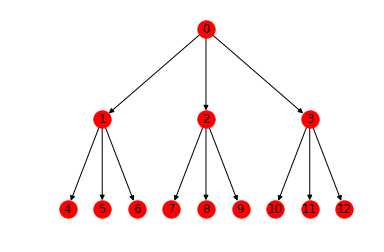

In [6]:
nice_tree_plot(g)

In [7]:
alpha_dict = dict()
for n in g.nodes():
    if g.out_degree(n) > 0:
        nbrs = list(g.neighbors(n))
        alpha_dict[n] = np.array([sp.symbols('a_{}_{}'.format(n, x)) for x in nbrs], dtype='object')
alpha = AlphaCalc.create(alpha_dict)
alpha.values

{0: array([a_0_1, a_0_2, a_0_3], dtype=object),
 1: array([a_1_4, a_1_5, a_1_6], dtype=object),
 2: array([a_2_7, a_2_8, a_2_9], dtype=object),
 3: array([a_3_10, a_3_11, a_3_12], dtype=object)}

In [8]:
R, leaf_paths = compute_combo_tensor_pam(g, alpha=alpha, ndarray_kwargs={"dtype": "object"}, return_leaf_paths=True)
R.shape

(9, 9)

In [9]:
leaf_to_index = {p[-1]: i for i, p in enumerate(leaf_paths)}
leaf_to_index

{4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7, 12: 8}

In [10]:
def R_leaf(L1, L2, R, leaf_to_index):
    i1 = leaf_to_index[L1]
    i2 = leaf_to_index[L2]
    return R[i1, i2]

In [11]:
def RL(L1, L2):
    global leaf_to_index, R
    return R_leaf(L1, L2, R, leaf_to_index)

In [12]:
show_math(RL(4,4)/RL(5,5))

<IPython.core.display.Math object>

In [13]:
show_math(RL(4,5))

<IPython.core.display.Math object>

In [14]:
show_math(RL(4,4))

<IPython.core.display.Math object>

In [15]:
sums = [x.simplify() for x in np.sum(R, axis=0)]
show_math(sums)

<IPython.core.display.Math object>

In [16]:
np.sum(sums).simplify()

1

In [17]:
show_math((RL(4,5) / RL(4,4)).simplify())

<IPython.core.display.Math object>

In [18]:
show_math((RL(4,5) / RL(5,5)).simplify())

<IPython.core.display.Math object>

In [19]:
show_math((RL(4,6) / RL(6,6)).simplify())

<IPython.core.display.Math object>

In [20]:
show_math((RL(4,6) / RL(4,4)).simplify())

<IPython.core.display.Math object>

In [21]:
def Ra(a,b):
    return sp.Symbol("R_{}_{}".format(a,b))

In [22]:
show_math(sp.Eq(
    (RL(4,6) / RL(4,4)).simplify(),
    Ra(4,6) / Ra(4,4)
))

<IPython.core.display.Math object>

In [23]:
eqs = []
for cluster in [[4,5,6], [7,8,9], [10,11,12]]:
    for n in cluster:
        for m in cluster:
            if m <= n:
                continue
            eqs.append(sp.Eq(
                (RL(m,n) / RL(m,m)).simplify(),
                Ra(m,n) / Ra(m,m)
            ))

In [24]:
show_math(eqs)

<IPython.core.display.Math object>

In [25]:
show_math(sp.solve(eqs, sp.symbols("a_1_4, a_1_5, a_1_6, a_2_7, a_2_8, a_2_9, a_3_10, a_3_11, a_3_12")))

<IPython.core.display.Math object>

In [26]:
def cross_multiply(eqn):
    lhs, rhs = eqn.args
    lnumer, ldenom = sp.fraction(lhs)
    rnumer, rdenom = sp.fraction(rhs)
    lhs = lnumer * rdenom
    rhs = rnumer * ldenom
    return sp.Eq(lhs, rhs)

In [27]:
class Analyzer(object):
    '''grouping some functions so it's easier to have multiple analyses in the same notebook'''
    def __init__(self, g):
        self.g = g

        alpha_dict = dict()
        for n in self.g.nodes():
            if self.g.out_degree(n) > 0:
                nbrs = list(self.g.neighbors(n))
                alpha_dict[n] = np.array([sp.symbols('a_{}_{}'.format(n, x)) for x in nbrs], dtype='object')
        self.alpha = AlphaCalc.create(alpha_dict)

        self.R, self.leaf_paths = compute_combo_tensor_pam(
            self.g, alpha=self.alpha, ndarray_kwargs={"dtype": "object"}, return_leaf_paths=True)

        self.leaf_to_index = {p[-1]: i for i, p in enumerate(self.leaf_paths)}
        
    def RL(self, L1, L2):
        return R_leaf(L1, L2, self.R, self.leaf_to_index)
    
    def get_first_leaf(self, n):
        nbrs = list(self.g.neighbors(n))
        if len(nbrs) == 0:
            return n
        else:
            return self.get_first_leaf(nbrs[0])
                
    def solve(self):
        clusters = dict()
        for n in self.g.nodes():
            if self.g.out_degree(n) > 0:
                curr_cluster = []
                for m in self.g.neighbors(n):
                    curr_cluster.append(m)
                clusters[n] = curr_cluster

        eqs_by_cluster = dict()
        vars_by_cluster = dict()
        soln_by_cluster = dict()
        for parent, cluster in clusters.items():
            print("Solving for cluster with parent = {}".format(parent))
            csize = len(cluster)
            eqs = []
            if csize == 1:
                a = sp.Symbol("a_{}_{}".format(parent, cluster[0]))
                eqs = [sp.Eq(a, 1)]
            elif csize == 2:
                m = self.get_first_leaf(cluster[0])
                n = self.get_first_leaf(cluster[1])
                eqs = [
                    cross_multiply(sp.Eq(
                        (self.RL(m,n) / self.RL(m,m)).simplify(),
                        Ra(m,n) / Ra(m,m)
                    )),
                    cross_multiply(sp.Eq(
                        (self.RL(m,n) / self.RL(n,n)).simplify(),
                        Ra(m,n) / Ra(n,n)
                    )),
                ]
            else:
                for i in range(csize):
                    m = self.get_first_leaf(cluster[i])
                    n = self.get_first_leaf(cluster[(i + 1) % csize])
                    eqs.append(cross_multiply(sp.Eq(
                        (self.RL(m,n) / self.RL(m,m)).simplify(),
                        Ra(m,n) / Ra(m,m)
                    )))
            eqs_by_cluster[parent] = eqs
            v = [sp.symbols("a_{}_{}".format(parent, n)) for n in cluster]
            vars_by_cluster[parent] = v
            soln_by_cluster[parent] = sp.solve(eqs, v)
        
        self.eqs_by_cluster = eqs_by_cluster
        self.vars_by_cluster = vars_by_cluster
        self.soln_by_cluster = soln_by_cluster

In [28]:
g2 = make_tree([2,4])

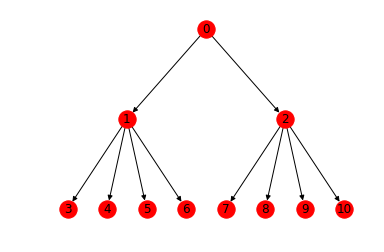

In [29]:
nice_tree_plot(g2)

In [30]:
analyzer = Analyzer(g2)

In [31]:
show_math(analyzer.RL(3,3) / analyzer.RL(3,7))

<IPython.core.display.Math object>

In [32]:
show_math(analyzer.RL(3,3) / analyzer.RL(3,4))

<IPython.core.display.Math object>

In [33]:
analyzer.solve()
show_math(analyzer.soln_by_cluster)

Solving for cluster with parent = 0
Solving for cluster with parent = 1
Solving for cluster with parent = 2


<IPython.core.display.Math object>

In [34]:
e = analyzer.eqs_by_cluster[0][0].args[0]
e

R_3_3*a_0_2*a_2_7*(a_1_3 + a_1_4 + a_1_5 + a_1_6 + 1)

In [35]:
sp.srepr(e)

"Mul(Symbol('R_3_3'), Symbol('a_0_2'), Symbol('a_2_7'), Add(Symbol('a_1_3'), Symbol('a_1_4'), Symbol('a_1_5'), Symbol('a_1_6'), Integer(1)))"

In [36]:
def pprint(e):
    if hasattr(e, "args") and e.args:
        nodes = [pprint(x) for x in e.args]
        return e.__class__.__name__ + "\n" + sp.printing.tree.pprint_nodes(nodes)
    else:
        return " " + str(e)

In [37]:
print(pprint(e))

Mul
+- R_3_3
+- a_0_2
+- a_2_7
+-Add
  +- 1
  +- a_1_3
  +- a_1_4
  +- a_1_5
  +- a_1_6



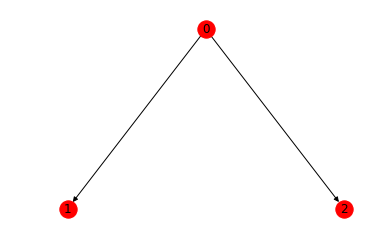

In [38]:
g3 = make_tree([2])
nice_tree_plot(g3)

In [39]:
analyzer = Analyzer(g3)

In [40]:
analyzer.solve()
show_math(analyzer.soln_by_cluster)

Solving for cluster with parent = 0


<IPython.core.display.Math object>

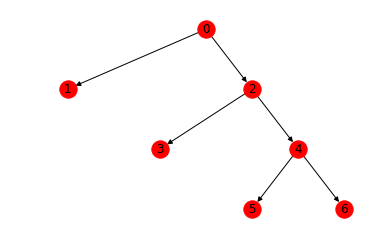

In [41]:
g4 = nx.DiGraph([(2*i, 2*i + 2) for i in range(3)] + [(2*i, 2*i + 1) for i in range(3)])
g4.graph["root"] = 0
nice_tree_plot(g4)

In [42]:
analyzer = Analyzer(g4)

In [43]:
analyzer.solve()
show_math(analyzer.soln_by_cluster)

Solving for cluster with parent = 0
Solving for cluster with parent = 2
Solving for cluster with parent = 4


<IPython.core.display.Math object>

In [54]:
show_math(analyzer.RL(1,1))
show_math(analyzer.RL(3,3))
show_math(analyzer.RL(5,5))
print("*"*20)
show_math(analyzer.RL(1,5))
print("RATIO:")
show_math(analyzer.RL(1,5) / analyzer.RL(5,5))
print("*"*20)
show_math(analyzer.RL(3,5))
print("RATIO:")
show_math(analyzer.RL(3,5) / analyzer.RL(5,5))
print("*"*20)
show_math(analyzer.RL(5,6))
print("RATIO:")
show_math(analyzer.RL(5,6) / analyzer.RL(5,5))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

********************


<IPython.core.display.Math object>

RATIO:


<IPython.core.display.Math object>

********************


<IPython.core.display.Math object>

RATIO:


<IPython.core.display.Math object>

********************


<IPython.core.display.Math object>

RATIO:


<IPython.core.display.Math object>

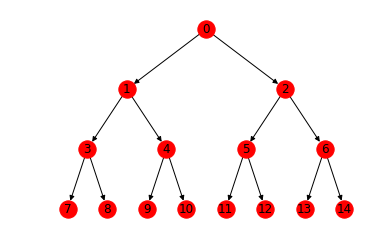

In [56]:
g5 = make_tree([2,2,2])
nice_tree_plot(g5)

In [57]:
analyzer = Analyzer(g5)

In [73]:
indices = [7, 8, 9, 11]

for j in indices:
    i = indices[0]
    show_math(sp.Eq(Ra(i,j), analyzer.RL(i,j)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [74]:
for j in indices[1:]:
    i = indices[0]
    show_math(sp.Eq(Ra(i,j) / Ra(i,i), analyzer.RL(i,j) / analyzer.RL(i,i)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [76]:
show_math(sp.Eq(Ra(8,8) / Ra(7,7), analyzer.RL(8,8) / analyzer.RL(7,7)))

<IPython.core.display.Math object>